In [3]:
# Import Libraries
import ast
import joblib  # Required for saving and loading models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, f1_score, precision_score, 
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

c:\Users\MSI\Downloads\stageee\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

df = pd.read_csv(r"C:\Users\MSI\Downloads\credit_synthetic.csv")
df.head()


,full_name,first_name,last_name,birthdate,age,id_number,nationality,address,phone,email,...,savings,assets_value,credit_type,credit_amount,credit_duration_months,credit_purpose,guarantee,dti,risk_score,default
0,Meriem Zribi,Meriem,Zribi,1959-12-28,66,10000000,Tunisienne,"50 rue Example, Tunis",232928708,meriem.zribi0@example.com,...,10,4114,Personnel,8174,58,Projet personnel,Salaire domicilié,0.094079,0.266226,0
1,Mohamed Naceur,Mohamed,Naceur,1952-03-30,73,10000001,Française,"64 rue Example, Nabeul",295656500,mohamed.naceur1@example.com,...,513,3642,Immobilier,75987,69,Achat maison,Hypothèque,0.381720,0.378322,0
2,Hend Mansouri,Hend,Mansouri,1974-09-04,51,10000002,Tunisienne,"72 rue Example, Nabeul",249166271,hend.mansouri2@example.com,...,13018,85728,Personnel,7876,49,Projet personnel,Salaire domicilié,0.179819,0.234838,0
3,Nada Zribi,Nada,Zribi,1971-12-21,54,10000003,Italienne,"143 rue Example, Sfax",220997276,nada.zribi3@example.com,...,16204,0,Consommation,500,7,Dépenses personnelles,Caution,0.043055,0.285848,0
4,Walid Sayadi,Walid,Sayadi,1970-01-10,55,10000004,Italienne,"77 rue Example, Bizerte",273561576,walid.sayadi4@example.com,...,534,0,Auto,17882,37,Achat voiture,Gage voiture,0.245453,0.388425,0


In [5]:
print("Shape:", df.shape)
print("\nTypes de données :\n", df.dtypes)


Shape: (2000, 37)

Types de données :
 full_name                          object
first_name                         object
last_name                          object
birthdate                          object
age                                 int64
id_number                           int64
nationality                        object
address                            object
phone                               int64
email                              object
marital_status                     object
children                            int64
profession                         object
employer                           object
sector                             object
company_address                    object
contract_type                      object
seniority_months                    int64
net_salary                          int64
other_income                        int64
household_income                    int64
fixed_expenses                      int64
existing_loans                       

In [6]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)


,Missing Values,Percent


In [7]:
df.describe(include='all')


,full_name,first_name,last_name,birthdate,age,id_number,nationality,address,phone,email,...,savings,assets_value,credit_type,credit_amount,credit_duration_months,credit_purpose,guarantee,dti,risk_score,default
count,2000,2000,2000,2000,2000.000000,2.000000e+03,2000,2000,2.000000e+03,2000,...,2000.000000,2000.000000,2000,2000.000000,2000.000000,2000,2000,2000.000000,2000.000000,2000.00000
unique,225,15,15,1896,NaN,NaN,5,1282,NaN,2000,...,NaN,NaN,5,NaN,NaN,5,5,NaN,NaN,NaN
top,Amina Riahi,Oumeyma,Toumi,1961-04-29,NaN,NaN,Tunisienne,"16 rue Example, Kébili",NaN,ahmed.ghozzi1983@example.com,...,NaN,NaN,Consommation,NaN,NaN,Dépenses personnelles,Caution,NaN,NaN,NaN
freq,17,159,148,3,NaN,NaN,1381,6,NaN,1,...,NaN,NaN,693,NaN,NaN,693,520,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,49.541500,1.000100e+07,NaN,NaN,2.560152e+08,NaN,...,5069.304500,33738.791500,NaN,21216.330000,58.826500,NaN,NaN,9.832626,0.447043,0.43050
std,NaN,NaN,NaN,NaN,14.609928,5.774946e+02,NaN,NaN,2.610681e+07,NaN,...,6604.510908,49080.955506,NaN,40630.418497,59.530617,NaN,NaN,93.978996,0.249851,0.49527
min,NaN,NaN,NaN,NaN,25.000000,1.000000e+07,NaN,NaN,2.100124e+08,NaN,...,1.000000,0.000000,NaN,500.000000,6.000000,NaN,NaN,0.001413,0.012059,0.00000
25%,NaN,NaN,NaN,NaN,37.000000,1.000050e+07,NaN,NaN,2.334849e+08,NaN,...,1018.000000,0.000000,NaN,4445.500000,28.000000,NaN,NaN,0.077419,0.264159,0.00000
50%,NaN,NaN,NaN,NaN,49.000000,1.000100e+07,NaN,NaN,2.565182e+08,NaN,...,2266.500000,10640.000000,NaN,8568.500000,45.000000,NaN,NaN,0.179637,0.400502,0.00000
75%,NaN,NaN,NaN,NaN,63.000000,1.000150e+07,NaN,NaN,2.790372e+08,NaN,...,5889.250000,54169.750000,NaN,17502.750000,65.000000,NaN,NaN,0.378512,0.570923,1.00000


In [8]:
df.duplicated().sum()


np.int64(0)

Très bonne question 👌 je t’explique en détail les 3 colonnes :

🔹 dti (Debt-To-Income ratio)

Définition : c’est le ratio entre les dettes mensuelles (mensualités de crédits, pensions à payer, etc.) et le revenu mensuel net.

Formule :

DTI
=
d
e
ˊ
penses mensuelles fixes li
e
ˊ
es aux dettes
revenu mensuel net
×
100
DTI=
revenu mensuel net
d
e
ˊ
penses mensuelles fixes li
e
ˊ
es aux dettes
	​

×100

Interprétation :

DTI < 30% → Profil sain, faible charge de dettes.

30% ≤ DTI ≤ 50% → Zone intermédiaire, risque moyen.

DTI > 50% → Profil à risque (plus de la moitié du revenu part dans les dettes).

🔹 risk_score

Définition : un score de risque de crédit (inspiré du modèle FICO ou bancaire).

Échelle (ici simulée de 300 à 850) :

300 – 579 → Risque très élevé (mauvais payeur probable).

580 – 669 → Risque moyen-faible.

670 – 739 → Bon profil.

740 – 799 → Très bon profil.

800 – 850 → Excellent profil, très faible risque.

Usage : plus le score est élevé, plus la banque a confiance dans la capacité de remboursement du client.

🔹 default

Définition : variable binaire indiquant si le client est susceptible de faire défaut (ne pas rembourser son crédit).

Valeurs :

0 → Pas de défaut (le client rembourse correctement).

1 → Défaut (probabilité élevée que le client ne rembourse pas).

Génération dans le dataset : dépend du dti et du risk_score.

Par exemple : un client avec un DTI élevé et un risk_score bas a beaucoup plus de chances d’avoir default = 1.

👉 En résumé :

dti = mesure la charge de dettes par rapport aux revenus.

risk_score = score de fiabilité financière du client.

default = résultat final : le client est considéré à risque (1) ou non (0).

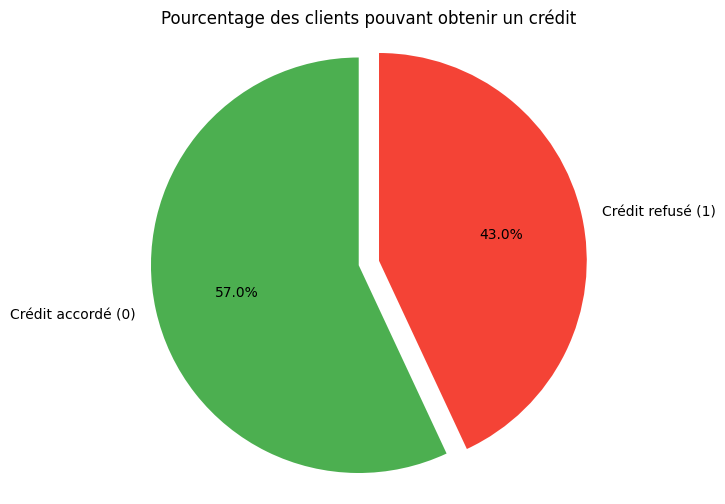

In [9]:
import matplotlib.pyplot as plt

# Comptage des classes
credit_counts = df['default'].value_counts()
labels = ['Crédit accordé (0)', 'Crédit refusé (1)']
colors = ['#4CAF50', '#F44336']  # vert et rouge
explode = [0, 0.1]  # pour détacher la partie "refusé"

# Création du camembert
plt.figure(figsize=(6,6))
plt.pie(credit_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title("Pourcentage des clients pouvant obtenir un crédit")
plt.axis('equal')  # cercle parfait
plt.show()


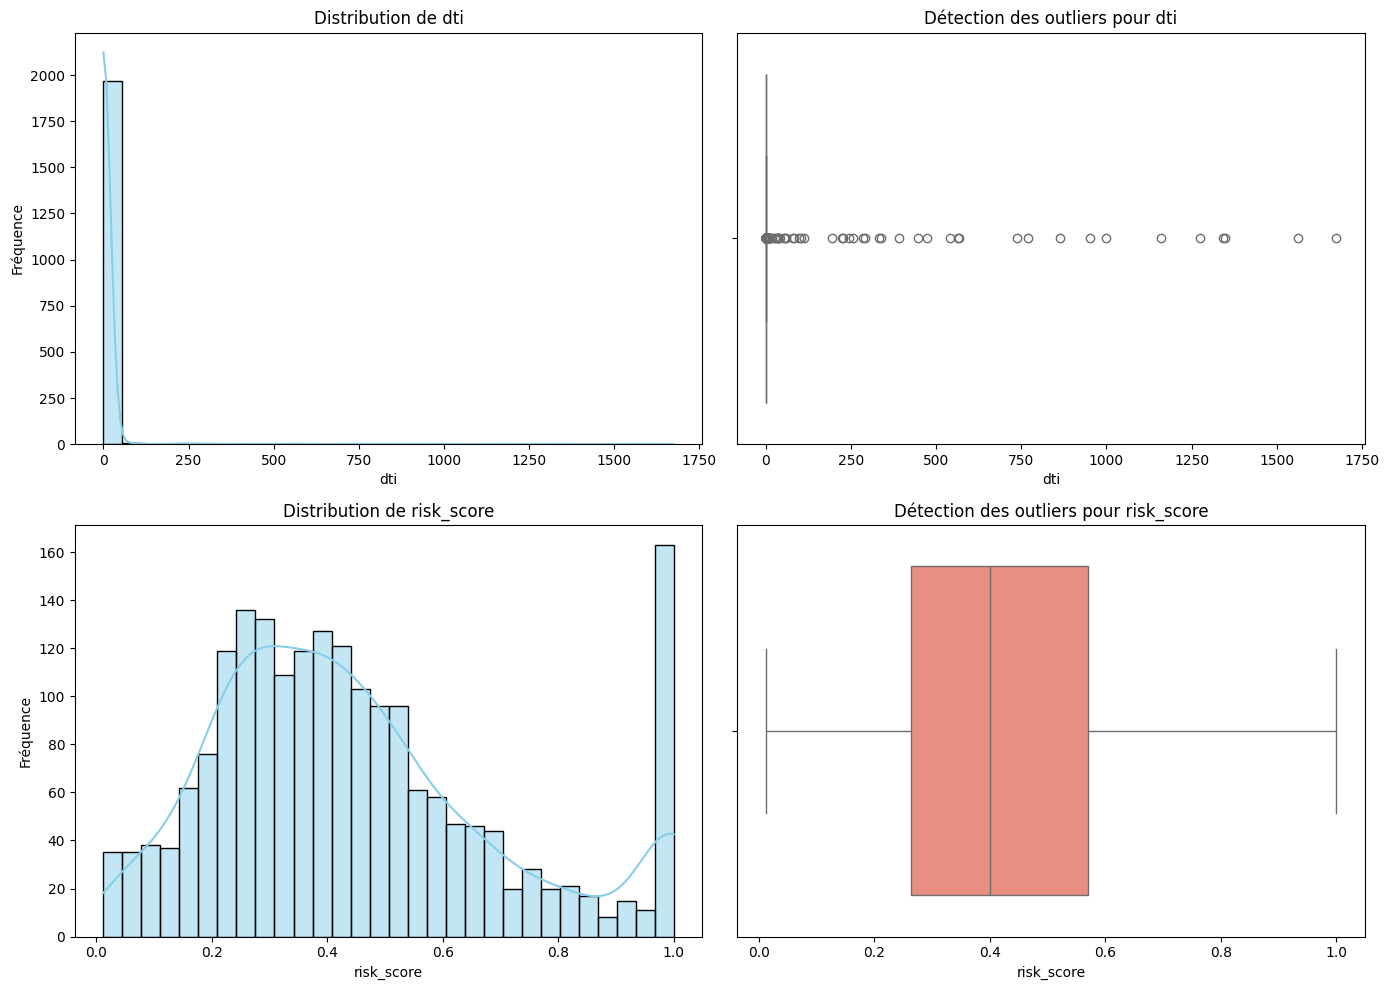

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes importantes à analyser
important_cols = ['dti', 'risk_score']  # Ajoute ici d'autres colonnes si nécessaire

# Taille de la figure
plt.figure(figsize=(14, len(important_cols) * 5))

# Boucle sur chaque colonne
for i, col in enumerate(important_cols):
    # Histogramme
    plt.subplot(len(important_cols), 2, 2*i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

    # Boxplot
    plt.subplot(len(important_cols), 2, 2*i + 2)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Détection des outliers pour {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul du pourcentage moyen de crédit accordé par État
state_credit_pct = df.groupby('state')['default'].apply(lambda x: (x == 0).mean() * 100).sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(12,6))
sns.barplot(x=state_credit_pct.index, y=state_credit_pct.values, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel("Pourcentage de clients éligibles au crédit (%)")
plt.xlabel("État")
plt.title("Pourcentage moyen de crédit accordé par État")
plt.tight_layout()
plt.show()


KeyError: 'state'

C:\Users\MSI\AppData\Local\Temp\ipykernel_11736\3121277130.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_credit_pct = df.groupby('score_group')['default'].apply(lambda x: (x == 0).mean() * 100)
C:\Users\MSI\AppData\Local\Temp\ipykernel_11736\3121277130.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_credit_pct.index, y=score_credit_pct.values, palette='coolwarm')


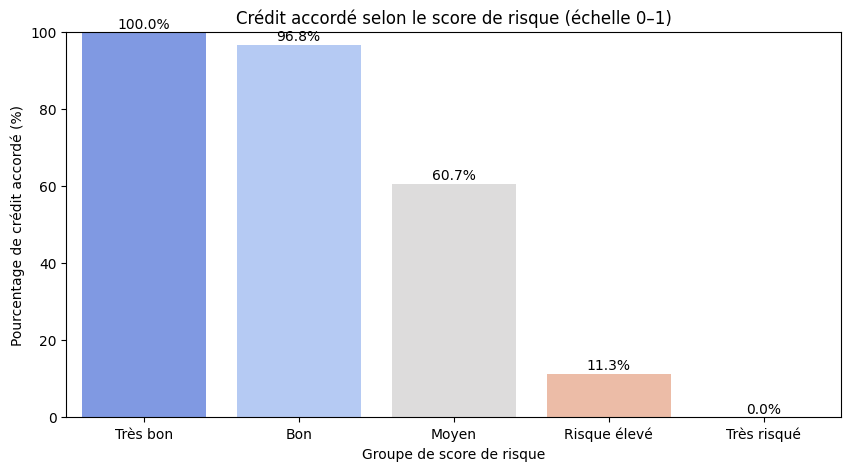

In [12]:
# Création de tranches de score
# Tranches de score entre 0 et 1
df['score_group'] = pd.cut(df['risk_score'], 
                           bins=[0, 0.2, 0.35, 0.5, 0.65, 1],
                           labels=['Très bon', 'Bon', 'Moyen', 'Risque élevé', 'Très risqué'],
                           include_lowest=True)


# Pourcentage de crédit accordé par groupe
score_credit_pct = df.groupby('score_group')['default'].apply(lambda x: (x == 0).mean() * 100)

# Visualisation


plt.figure(figsize=(10,5))
sns.barplot(x=score_credit_pct.index, y=score_credit_pct.values, palette='coolwarm')
plt.ylabel("Pourcentage de crédit accordé (%)")
plt.xlabel("Groupe de score de risque")
plt.title("Crédit accordé selon le score de risque (échelle 0–1)")
plt.ylim(0, 100)

# Ajout des pourcentages sur les barres
for i, val in enumerate(score_credit_pct.values):
    plt.text(i, val + 1, f'{val:.1f}%', ha='center')

plt.show()


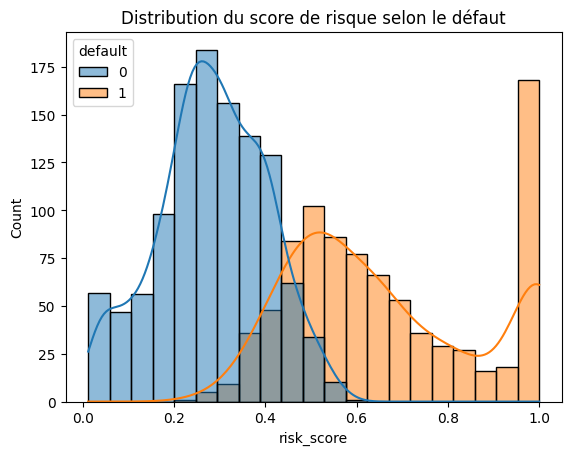

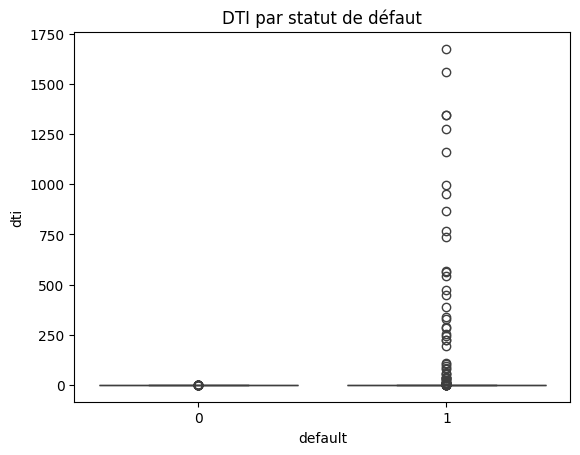

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='risk_score', hue='default', kde=True)
plt.title("Distribution du score de risque selon le défaut")
plt.show()

sns.boxplot(data=df, x='default', y='dti')
plt.title("DTI par statut de défaut")
plt.show()


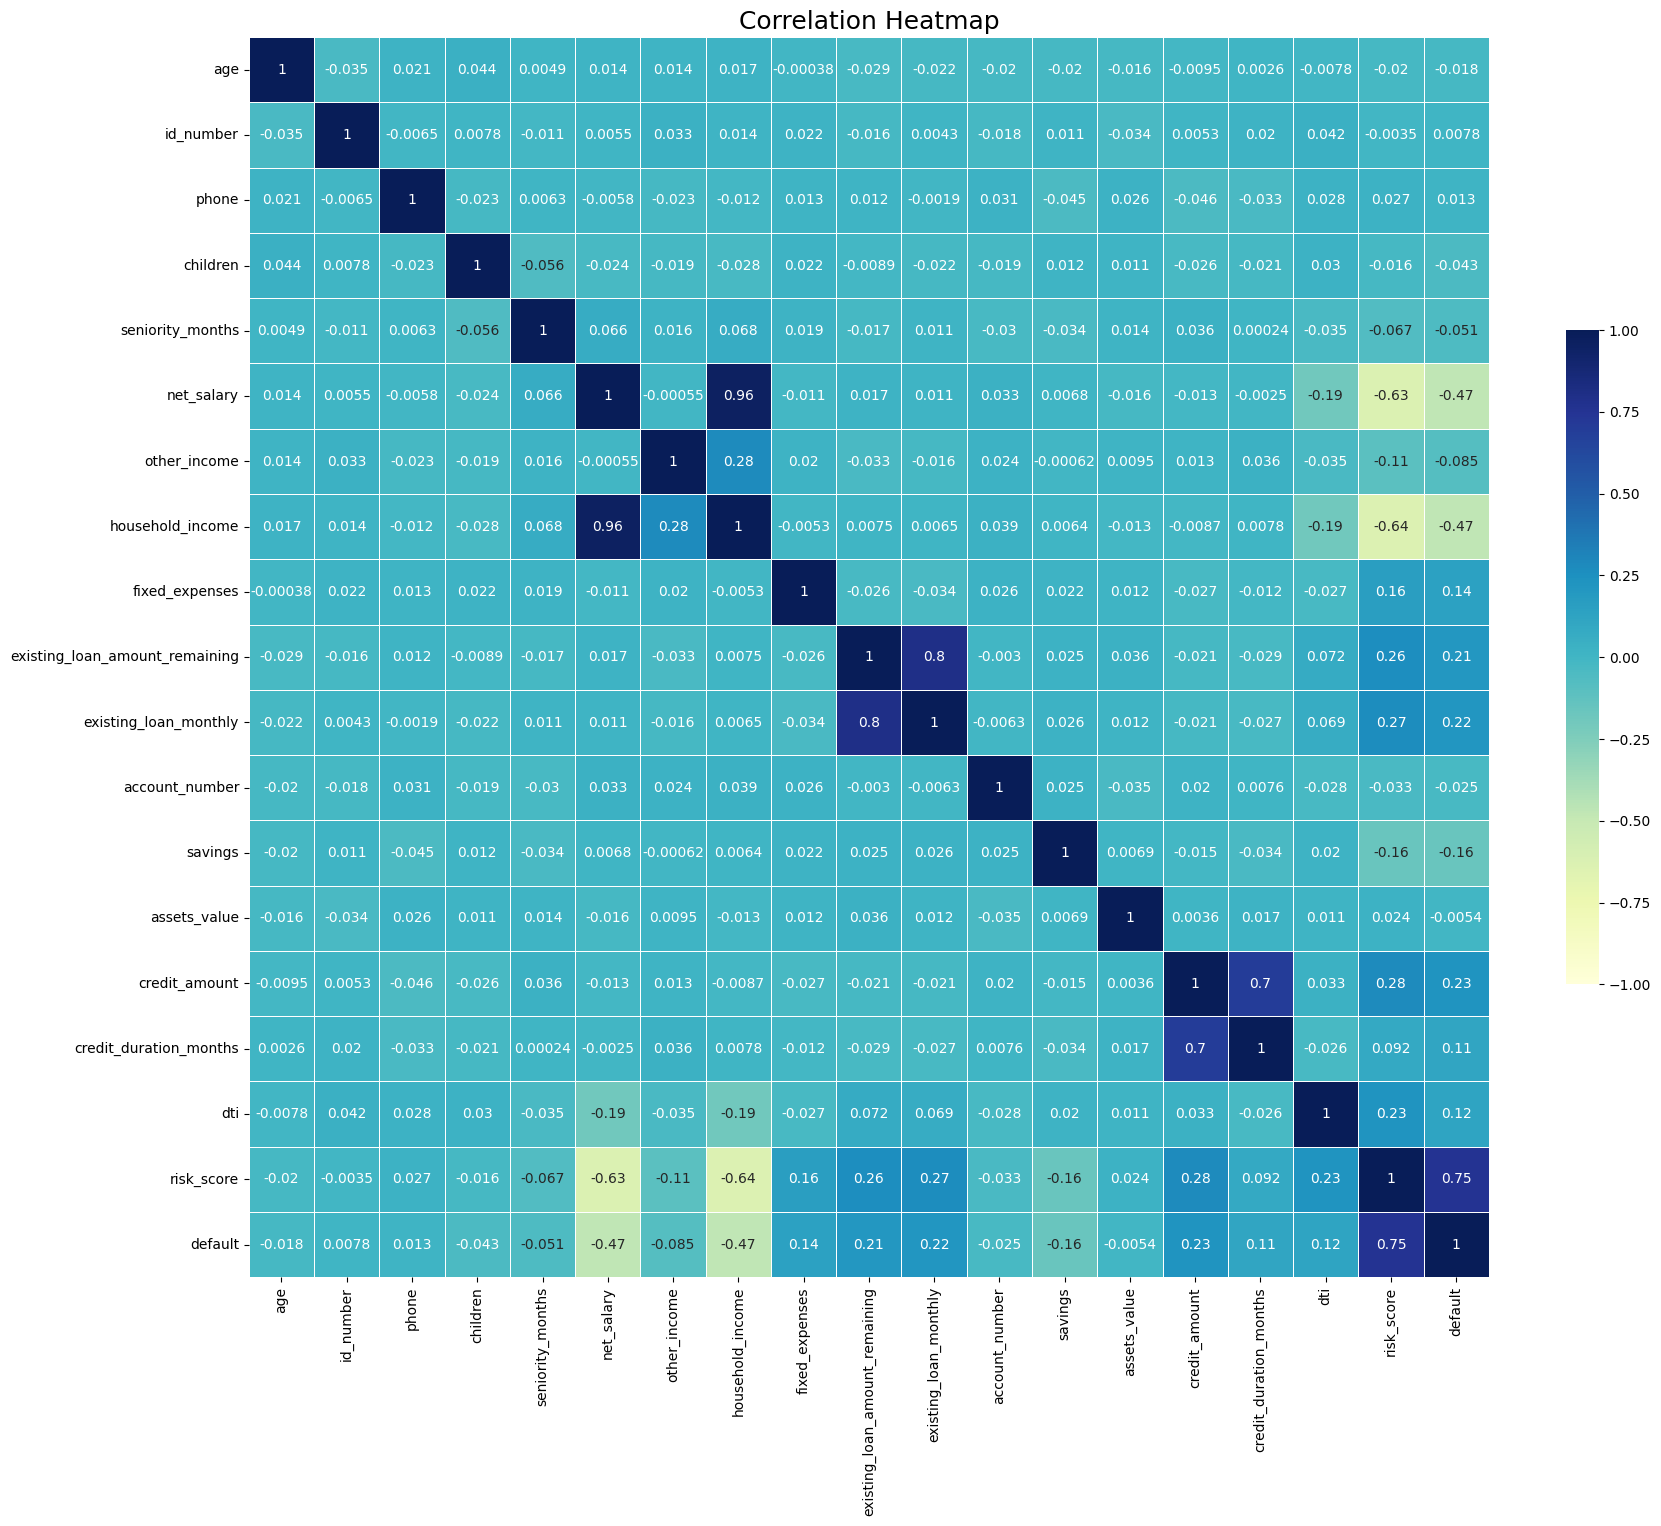

In [14]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = numeric_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 17))

# Draw the heatmap with no mask
sns.heatmap(
    corr,
    cmap="YlGnBu",
    vmin=-1,
    vmax=1,
    annot=True,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title("Correlation Heatmap", fontsize=18)
plt.show()


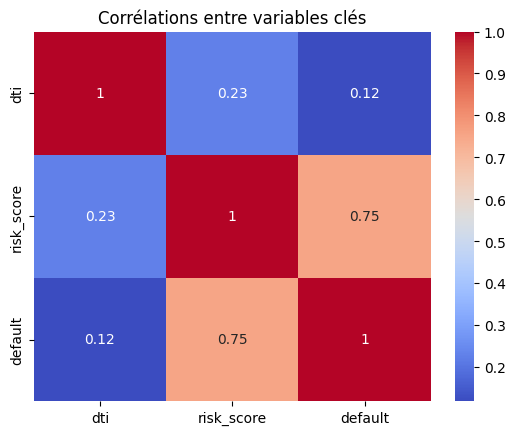

In [15]:
corr = df[['dti', 'risk_score', 'default']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Corrélations entre variables clés")
plt.show()


In [16]:
# Binarisation du DTI
df['dti_risk'] = df['dti'].apply(lambda x: 1 if x > 0.5 else 0)

# Regroupement du score de risque
df['score_group'] = pd.cut(df['risk_score'], bins=[0, 0.2, 0.35, 0.5, 0.65, 1],
                           labels=['Très bon', 'Bon', 'Moyen', 'Risque élevé', 'Très risqué'])

# Encodage des groupes
df = pd.get_dummies(df, columns=['score_group'], drop_first=True)


In [17]:
obj_cols = df.select_dtypes(include='object').columns.tolist()
print("Colonnes à encoder :", obj_cols)


Colonnes à encoder : ['full_name', 'first_name', 'last_name', 'birthdate', 'nationality', 'address', 'email', 'marital_status', 'profession', 'employer', 'sector', 'company_address', 'contract_type', 'bank', 'credit_type', 'credit_purpose', 'guarantee']


In [18]:
cols_to_drop = [
    'full_name', 'first_name', 'last_name', 'birthdate',
    'address', 'email', 'company_address', 'employer', 'guarantee','nationality','marital_status','credit_type','contract_type','profession', 'sector', 'bank', 'credit_purpose'
]

df_cleaned = df.drop(columns=cols_to_drop)


In [19]:
mapping = {
    'Crédit consommation': 1,
    'Crédit auto': 2,
    'Crédit personnel': 3,
    'Regroupement de crédits': 4,
    'Crédit immobilier': 5
}
df_cleaned ['credit_type_encoded'] = df['credit_type'].map(mapping)


In [20]:
contract_order = {
    'CDI': 1,
    'Retraité': 2,
    'CDD': 3,
    'Indépendant / Freelance': 4,
    'Autre': 5
}
df_cleaned['contract_type_encoded'] = df['contract_type'].map(contract_order)


In [21]:
obj_cols = df_cleaned.select_dtypes(include='object').columns.tolist()
print("Colonnes à encoder :", obj_cols)


Colonnes à encoder : []


In [22]:
df_cleaned.to_csv('df_encoded.csv', index=False)

# **4. Modeling**

In [23]:
df_encoded=pd.read_csv('df_encoded.csv')

In [24]:
# Séparer les features et la target
X = df_encoded.drop(columns=['default'])
y = df_encoded['default']
# Diviser en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)

Taille de l'ensemble d'entraînement : (1600, 26)
Taille de l'ensemble de test : (400, 26)


Feature Importance:
                           Feature  Importance
18                      risk_score    0.720153
5                       net_salary    0.037572
17                             dti    0.031852
2                            phone    0.030773
16          credit_duration_months    0.023494
7                 household_income    0.021206
8                   fixed_expenses    0.017604
1                        id_number    0.016923
4                 seniority_months    0.016167
12                  account_number    0.014290
0                              age    0.013048
15                   credit_amount    0.012457
14                    assets_value    0.009208
10  existing_loan_amount_remaining    0.007912
3                         children    0.005443
11           existing_loan_monthly    0.005185
13                         savings    0.004460
19                        dti_risk    0.003547
9                   existing_loans    0.003314
25           contract_type_encoded    0.

C:\Users\MSI\AppData\Local\Temp\ipykernel_11736\1053561921.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


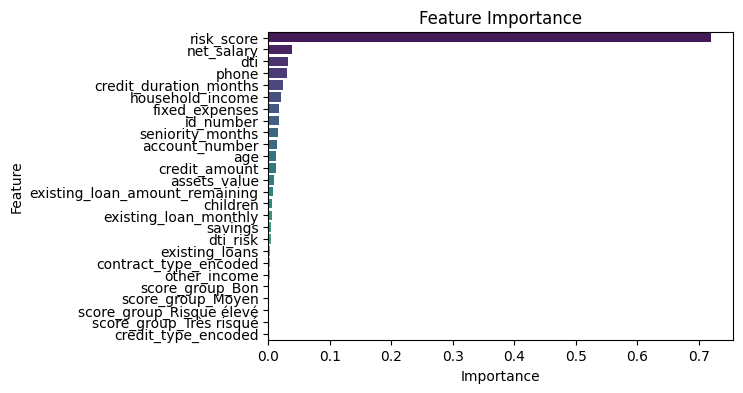

In [25]:
# Train Decision Tree model according to paper 1
rf_model = DecisionTreeClassifier(random_state=42)  # Adjust `n_estimators` and other parameters as needed
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)
# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()


Feature Importance:
                           Feature  Importance
18                      risk_score    0.341010
17                             dti    0.102032
23         score_group_Très risqué    0.057848
19                        dti_risk    0.048906
7                 household_income    0.044591
5                       net_salary    0.043854
20                 score_group_Bon    0.043789
22        score_group_Risque élevé    0.031870
13                         savings    0.030144
15                   credit_amount    0.024685
4                 seniority_months    0.022949
25           contract_type_encoded    0.022566
8                   fixed_expenses    0.022444
1                        id_number    0.022245
12                  account_number    0.020117
16          credit_duration_months    0.019255
0                              age    0.018754
21               score_group_Moyen    0.018328
2                            phone    0.018301
14                    assets_value    0.

C:\Users\MSI\AppData\Local\Temp\ipykernel_11736\2397385880.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


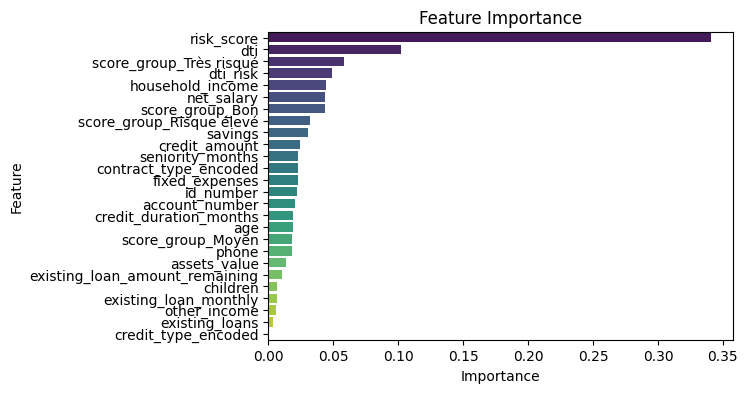

In [26]:
# Train rf model according to paper 1
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()


Feature Importance - XGBoost
                           Feature  Importance
18                      risk_score    0.516435
6                     other_income    0.045352
16          credit_duration_months    0.030976
10  existing_loan_amount_remaining    0.030014
14                    assets_value    0.029839
7                 household_income    0.028266
5                       net_salary    0.027824
17                             dti    0.027034
1                        id_number    0.026148
13                         savings    0.026075
15                   credit_amount    0.025599
8                   fixed_expenses    0.024288
0                              age    0.023684
3                         children    0.021992
12                  account_number    0.021828
2                            phone    0.021239
4                 seniority_months    0.020979
11           existing_loan_monthly    0.016776
21               score_group_Moyen    0.016039
25           contract_type_enco

C:\Users\MSI\AppData\Local\Temp\ipykernel_11736\3020463085.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


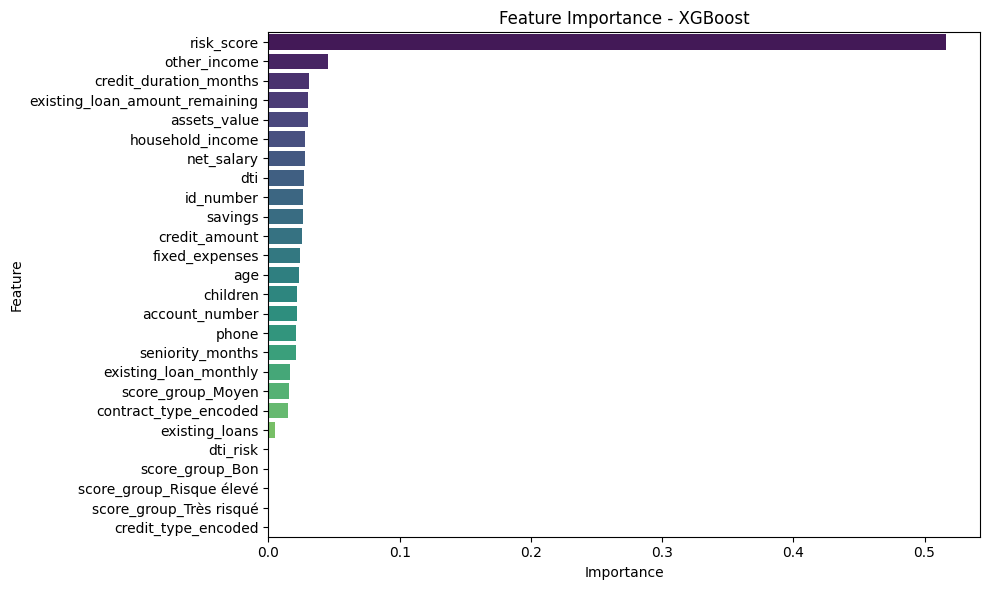

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


# Extraire les importances
importances = xgb_model.feature_importances_
features = X_train.columns

# Créer un DataFrame trié
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Afficher
print("Feature Importance - XGBoost")
print(feature_importance_df)

# Visualiser
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [28]:
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

comparison_df = pd.DataFrame({
    'Feature': X_train.columns,
    'RF Importance': rf_importances,
    'XGB Importance': xgb_importances
}).sort_values(by='XGB Importance', ascending=False)

print(comparison_df.head(10))


                           Feature  RF Importance  XGB Importance
18                      risk_score       0.341010        0.516435
6                     other_income       0.006164        0.045352
16          credit_duration_months       0.019255        0.030976
10  existing_loan_amount_remaining       0.010379        0.030014
14                    assets_value       0.013213        0.029839
7                 household_income       0.044591        0.028266
5                       net_salary       0.043854        0.027824
17                             dti       0.102032        0.027034
1                        id_number       0.022245        0.026148
13                         savings       0.030144        0.026075


In [29]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Initialisation
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Entraînement
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, roc_auc_score

models = {
    'XGBoost': xgb_model,
    'Random Forest': rf_model,
    'Decision Tree': dt_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(results_df)


           Model  Accuracy       AUC
1  Random Forest     0.890  0.956599
0        XGBoost     0.870  0.955120
2  Decision Tree     0.855  0.854957


In [30]:
import joblib
joblib.dump(dt_model, "credit_model.pkl")


['credit_model.pkl']

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

def train_and_evaluate_models(models, X_train_scaled, y_train, X_test_scaled, y_test):
    best_models = {}

    # 🔁 Entraînement + optimisation
    for name, (model, params) in models.items():
        print(f"🔧 Training {name}...")
        grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=1, verbose=0)
        grid.fit(X_train_scaled, y_train)
        best_models[name] = grid.best_estimator_
        print(f"✅ Best parameters for {name}: {grid.best_params_}")
        print(f"📊 Best cross-validated accuracy for {name}: {grid.best_score_:.4f}\n")

    # 📈 Évaluation sur le test set
    for name, model in best_models.items():
        print(f"🔍 Evaluating {name}...")
        y_pred = model.predict(X_test_scaled)
        print(f"🎯 Accuracy for {name}: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred))

        ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
        plt.title(f"Confusion Matrix for {name}")
        plt.show()

    # 💾 Sauvegarde des meilleurs modèles
    joblib.dump(best_models, 'best_models.joblib')
    print("📁 Models saved to 'best_models.joblib'")

    return best_models


In [113]:
import joblib
best_models = joblib.load('best_models.joblib')

# Exemple : accéder à chaque modèle individuellement
xgb_model = best_models['XGBoost']
rf_model = best_models['Random Forest']
dt_model = best_models['Decision Tree']
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_single_model(model, name, X_original, y_original, X_resampled, y_resampled):
    # Original
    y_pred_orig = model.predict(X_original)
    y_proba_orig = model.predict_proba(X_original)[:, 1]
    acc_orig = accuracy_score(y_original, y_pred_orig)
    prec_orig = precision_score(y_original, y_pred_orig)
    rec_orig = recall_score(y_original, y_pred_orig)
    f1_orig = f1_score(y_original, y_pred_orig)
    auc_orig = roc_auc_score(y_original, y_proba_orig)

    # Resampled
    y_pred_res = model.predict(X_resampled)
    y_proba_res = model.predict_proba(X_resampled)[:, 1]
    acc_res = accuracy_score(y_resampled, y_pred_res)
    prec_res = precision_score(y_resampled, y_pred_res)
    rec_res = recall_score(y_resampled, y_pred_res)
    f1_res = f1_score(y_resampled, y_pred_res)
    auc_res = roc_auc_score(y_resampled, y_proba_res)

    # Résumé
    summary = pd.DataFrame([{
        'Model': name,
        'Accuracy (Original)': acc_orig,
        'Precision (Original)': prec_orig,
        'Recall (Original)': rec_orig,
        'F1-Score (Original)': f1_orig,
        'ROC-AUC (Original)': auc_orig,
        'Accuracy (Resampled)': acc_res,
        'Precision (Resampled)': prec_res,
        'Recall (Resampled)': rec_res,
        'F1-Score (Resampled)': f1_res,
        'ROC-AUC (Resampled)': auc_res
    }])

    # Courbe ROC
    fpr_orig, tpr_orig, _ = roc_curve(y_original, y_proba_orig)
    fpr_res, tpr_res, _ = roc_curve(y_resampled, y_proba_res)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_orig, tpr_orig, label=f'Original (AUC = {auc_orig:.2f})', color='blue')
    plt.plot(fpr_res, tpr_res, label=f'Resampled (AUC = {auc_res:.2f})', color='green')
    plt.plot([0, 1], [0, 1], 'k--', color='gray')
    plt.title(f"{name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()

    return summary
X_resampled, y_resampled = prepare_data(X_train, y_train)

summary_xgb = evaluate_single_model(xgb_model, "XGBoost", X_test, y_test, X_resampled, y_resampled)
summary_rf = evaluate_single_model(rf_model, "Random Forest", X_test, y_test, X_resampled, y_resampled)
summary_dt = evaluate_single_model(dt_model, "Decision Tree", X_test, y_test, X_resampled, y_resampled)

# Afficher les résultats
print(summary_xgb)
print(summary_rf)
print(summary_dt)


FileNotFoundError: [Errno 2] No such file or directory: 'best_models.joblib'